In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt

## import data

In [2]:
Geography = np.zeros(62,dtype = 'object')
income_mean = np.zeros((62,7))
income_median = np.zeros((62,7))
total_pop = np.zeros((62,7))
black_pop = np.zeros((62,7))
white_pop = np.zeros((62,7))
black_rate = np.zeros((62,7))
white_rate = np.zeros((62,7))

In [3]:
file_list = ['Income/ACS_11_5YR_S1901_with_ann.csv','Income/ACS_12_5YR_S1901_with_ann.csv','Income/ACS_13_5YR_S1901_with_ann.csv',
             'Income/ACS_14_5YR_S1901_with_ann.csv','Income/ACS_15_5YR_S1901_with_ann.csv','Income/ACS_16_5YR_S1901_with_ann.csv',
             'Income/ACS_17_5YR_S1901_with_ann.csv']
file_list2 = ['Population/ACS_11_5YR_B02001_with_ann.csv','Population/ACS_12_5YR_B02001_with_ann.csv','Population/ACS_13_5YR_B02001_with_ann.csv',
              'Population/ACS_14_5YR_B02001_with_ann.csv','Population/ACS_15_5YR_B02001_with_ann.csv','Population/ACS_16_5YR_B02001_with_ann.csv',
              'Population/ACS_17_5YR_B02001_with_ann.csv']
for i in range(6):
    data1 = pd.read_csv(file_list[i],header = None, skiprows = [0,1], names = ['zipcode','income median','income mean'], usecols = [2,91,99])
    data2 = pd.read_csv(file_list2[i],header = None, skiprows = [0,1], names = ['zipcode', 'total', 'white', 'black'], usecols = [2,3,5,7])
    for j in range(62):
        Geography[j] = data1['zipcode'][j]
        income_mean[j,i] = data1['income mean'][j]
        income_median[j,i] = data1['income median'][j]
        total_pop[j,i] = data2['total'][j]
        white_pop[j,i] = data2['white'][j]
        black_pop[j,i] = data2['black'][j]
        white_rate[j,i] = white_pop[j,i]/total_pop[j,i]
        black_rate[j,i] = black_pop[j,i]/total_pop[j,i]
data1 = pd.read_csv(file_list[6],header = None, skiprows = [0,1], names = ['zipcode','income median','income mean'], usecols = [2,25,27])
data2 = pd.read_csv(file_list2[6],header = None, skiprows = [0,1], names = ['zipcode', 'total', 'white', 'black'], usecols = [2,3,5,7])
for j in range(62):
    Geography[j] = data1['zipcode'][j]
    income_mean[j,6] = data1['income mean'][j]
    income_median[j,6] = data1['income median'][j]
    total_pop[j,6] = data2['total'][j]
    white_pop[j,6] = data2['white'][j]
    black_pop[j,6] = data2['black'][j]
    white_rate[j,6] = white_pop[j,6]/total_pop[j,6]
    black_rate[j,6] = black_pop[j,6]/total_pop[j,6]


## describe data

In [4]:
Index1 = []
Index2 = []
for i in range(62):
    for j in range(7):
        Index1.append(Geography[i])
        Index2.append(2011+j)
Index = [Index1, Index2]
df = pd.DataFrame(np.zeros((62*7,9)), columns = ['Zip Code', 'Year', 'mean_income', 'median_income', 'total_pop', 
                                                 'black_pop', 'white_pop','black_rate', 'white_rate'])
for i in range(62):
    for j in range(7):
        df['Zip Code'][i*7+j] = int(Geography[i][6:])
        df['Year'][i*7+j] = 2011+j
        df['mean_income'][i*7+j] = income_mean[i,j]
        df['median_income'][i*7+j] = income_median[i,j]
        df['total_pop'][i*7+j] = total_pop[i,j]
        df['white_pop'][i*7+j] = white_pop[i,j]
        df['black_pop'][i*7+j] = black_pop[i,j]
        df['white_rate'][i*7+j] = white_rate[i,j]
        df['black_rate'][i*7+j] = black_rate[i,j]

In [5]:
df_summary1 = (df[['Year', 'mean_income', 'median_income']].groupby(['Year']).describe()).T
df_summary2 = (df[['Year', 'total_pop', 'black_pop', 'white_pop','black_rate', 'white_rate']].groupby(['Year']).describe()).T

## autoregression on black population

In [6]:
Matrix = np.ones((62*6,3))
for i in range(6):
    for j in range(62):
        Matrix[i*62+j,0] = black_pop[j,i]*(black_pop[j,i+1]>=1000)
        Matrix[i*62+j,1] = black_pop[j,i+1]*(black_pop[j,i+1]>=1000)
alpha = np.linalg.lstsq(Matrix[:,[0,2]].reshape(-1,2), Matrix[:,1].reshape(-1,1))[0][0]

C:\Users\ccb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


## define loss function on black population (using mean income)

In [7]:
def Loss(params):
    r = alpha
    b1, b2 = params
    Loss = []
    black_pre = np.zeros((62,7))
    black_pre[:,0] = black_pop[:,0]
    def pr(x1, x2, x3, x4):
        u1 = b1*np.log(x1) + b2*x2
        u2 = b1*np.log(x3) + b2*x4
        diff = u2-u1
        return 1/(1+np.exp(-diff))
    for i in range(6):
        probability = np.zeros((62,62))
        black_pop_end = np.zeros(62)
        black_pop_end_true = black_pop[:,i+1]
        income_start = income_mean[:,i]
        black_rate_start = black_rate[:,i]
        black_pop_start = black_pop[:,i]
        for j in range(62):
            for k in range(62):
                x1, x2, x3, x4 = income_start[j], black_rate_start[j], income_start[k], black_rate_start[k]
                probability[j,k] = pr(x1, x2, x3, x4)
        for q in range(62):
            probability[q,q] = 1
            total = probability[q,:].sum() - 1
            if total == 0:
                total = 1
            probability[q,:] = (1-r)*probability[q,:]/total
            probability[q,q] = r
        for p in range(62):
            black_pop_end[p] = (probability[:,p]*black_pop_start).sum()
        black_pre[:,i+1] = black_pop_end
        loss = (np.abs(black_pop_end[black_pop_end_true!=0]/black_pop_end_true[black_pop_end_true!=0]-1)).mean()
        Loss.append(loss)
    return np.array(Loss).sum()

In [8]:
def Mat(params, i=0):
    r = alpha
    b1, b2 = params
    Loss = []
    black_pre = np.zeros((62,7))
    black_pre[:,0] = black_pop[:,0]
    def pr(x1, x2, x3, x4):
        u1 = b1*np.log(x1) + b2*x2
        u2 = b1*np.log(x3) + b2*x4
        diff = u2-u1
        return 1/(1+np.exp(-diff))
    for i in range(6):
        probability = np.zeros((62,62))
        black_pop_end = np.zeros(62)
        black_pop_end_true = black_pop[:,i+1]
        income_start = income_mean[:,i]
        black_rate_start = black_rate[:,i]
        black_pop_start = black_pop[:,i]
        for j in range(62):
            for k in range(62):
                x1, x2, x3, x4 = income_start[j], black_rate_start[j], income_start[k], black_rate_start[k]
                probability[j,k] = pr(x1, x2, x3, x4)
        for q in range(62):
            probability[q,q] = 1
            total = probability[q,:].sum() - 1
            if total == 0:
                total = 1
            probability[q,:] = (1-r)*probability[q,:]/total
            probability[q,q] = r
        for p in range(62):
            black_pop_end[p] = (probability[:,p]*black_pop_start).sum()
        black_pre[:,i+1] = black_pop_end
    return black_pre

In [19]:
b1 = 0.1
b2 = 1
params_init = np.array([b1, b2])
results = opt.minimize(Loss, params_init, tol = 1e-14, bounds = [(1e-10,None),(None,None)])
params = results.x
params

array([1.00000000e-10, 3.77619612e+01])

In [20]:
Predict = Mat(params)

## draw graphs for error rate of prediction

C:\Users\ccb\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


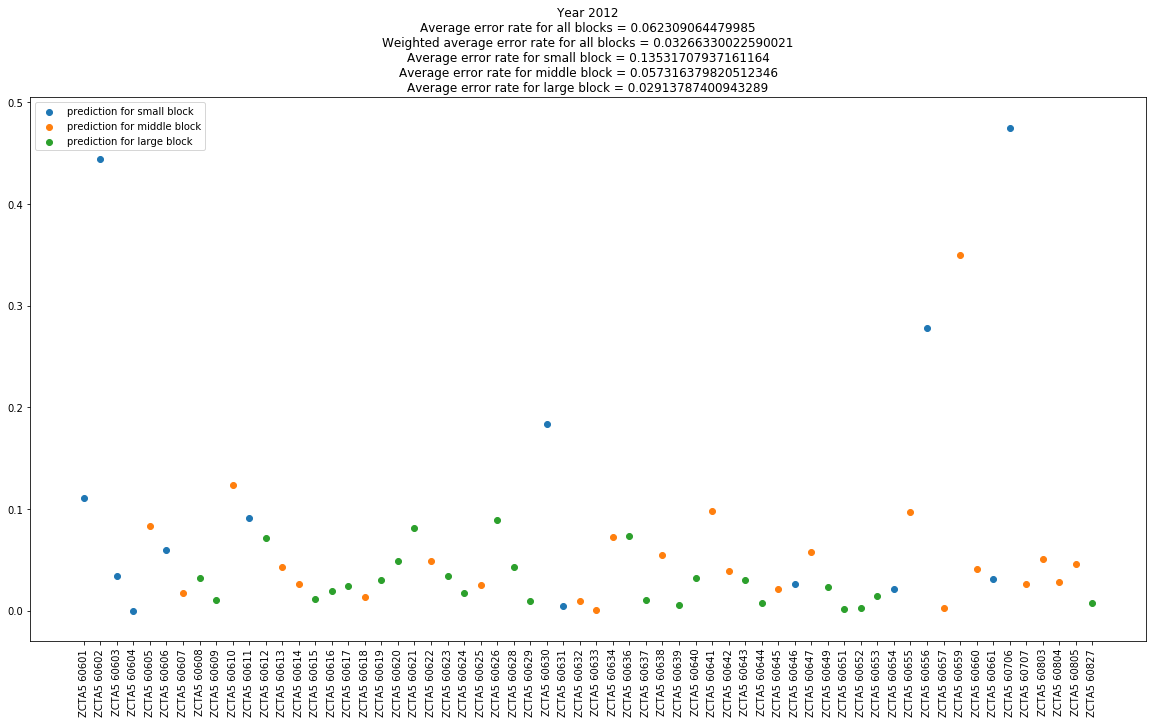

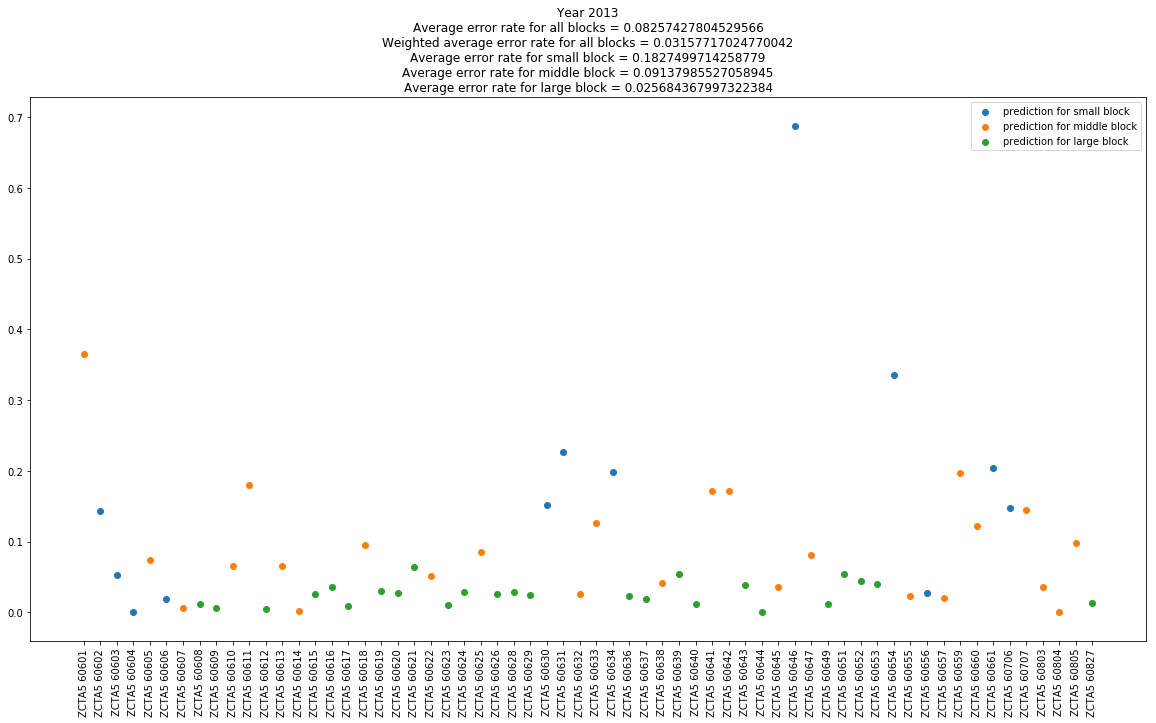

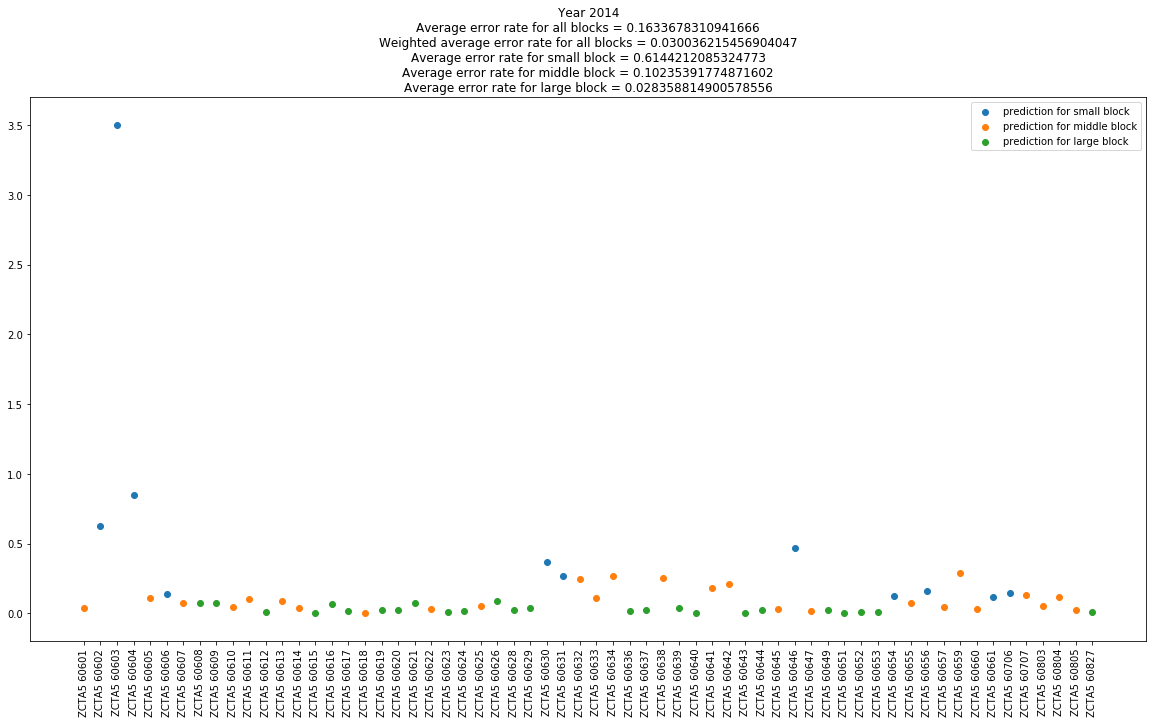

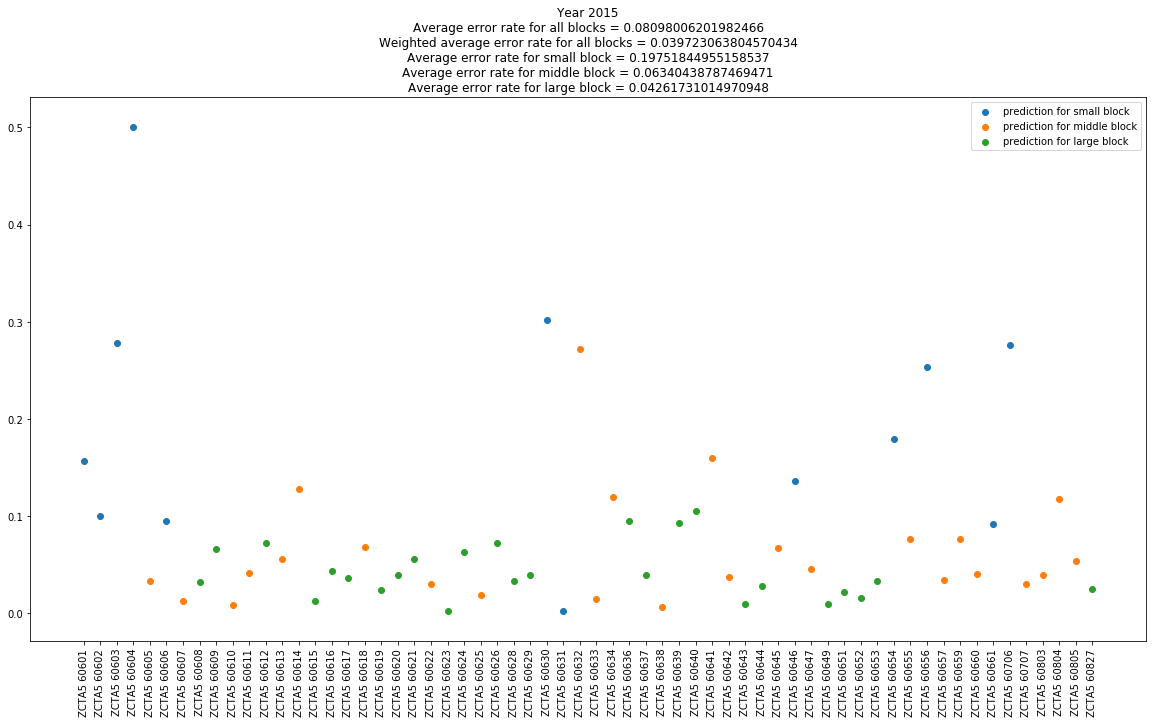

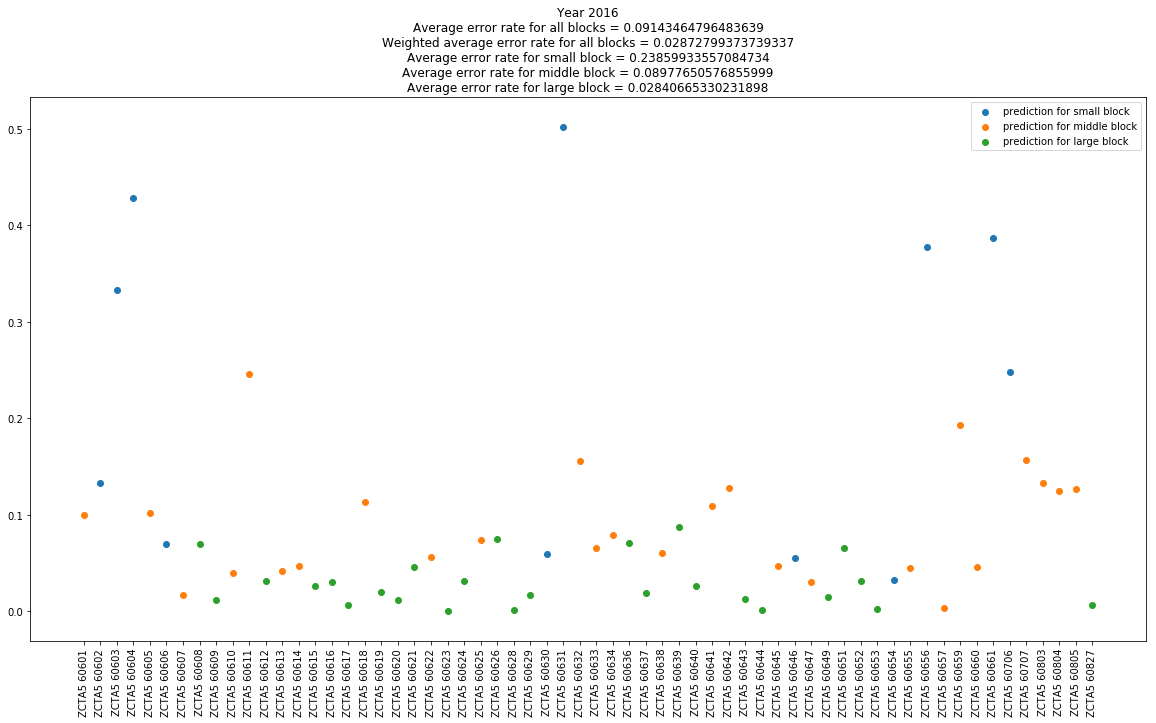

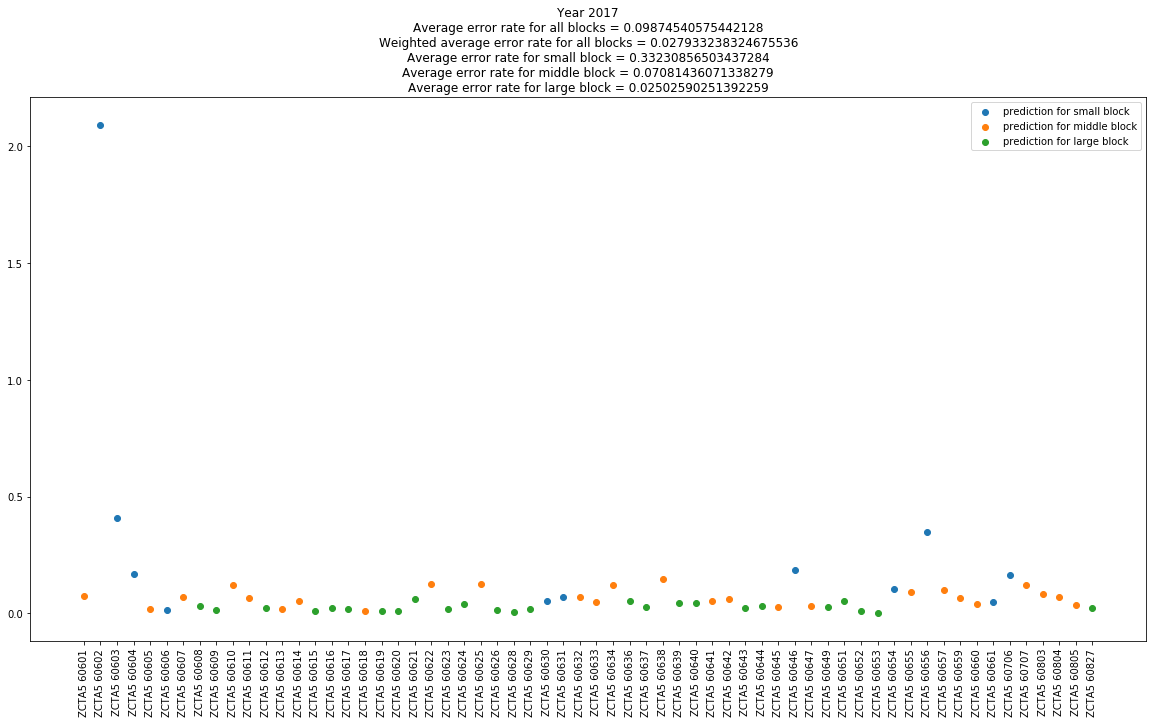

In [21]:
for k in range(6):
    predict = np.array(Predict[:,k+1], dtype = 'int')
    true = np.array(black_pop[:,k+1], dtype = 'int')
    Y1 = np.abs(predict/true-1)
    Y1[true==0] = 0
    err_avg = Y1.mean()
    err_avg1 = Y1[(true<1000)&(true>=0)].mean()
    err_avg_2 = Y1[(true<10000)&(true>=1000)].mean()
    err_avg_3 = Y1[true>10000].mean()
    err_avg_4 = (Y1*(true/(true.sum()))).sum()
    fig, ax = plt.subplots(figsize = (20,10))
    ax.scatter(Geography,Y1, color = 'white', label = None)
    ax.scatter(Geography[(true<1000)&(true>=0)],Y1[(true<1000)&(true>=0)], label = 'prediction for small block')
    ax.scatter(Geography[(true<10000)&(true>=1000)],Y1[(true<10000)&(true>=1000)], label = 'prediction for middle block')
    ax.scatter(Geography[true>=10000],Y1[true>=10000], label = 'prediction for large block')
    ax.set_title('Year {}'.format(2012+k) + '\nAverage error rate for all blocks = '+str(err_avg)+'\nWeighted average error rate for all blocks = '+str(err_avg_4)+'\nAverage error rate for small block = '+str(err_avg1) + '\nAverage error rate for middle block = '+str(err_avg_2)+'\nAverage error rate for large block = '+str(err_avg_3))
    ax.legend()
    plt.xticks(rotation=90)
    plt.show